In [26]:
# usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import warnings

from opcoes.black_scholes import bs_d_one
from opcoes.replication import run_delta_hedge_sim
from opcoes.simulation import generate_paths

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set() 

Two extensions:
 - portfolio of options to hedge
 - vega hedging at each time step

In [123]:
px = 100
risk_free = 0.00
divs = 0.00
sigma = 0.2
years = 1
points = 252*4
sims = 10000

strike = 60

## Standard Example

Starting delta of:

In [81]:
stats.norm.cdf(bs_d_one(100, 130, risk_free, divs, 0.2, years))

0.11279039221574855

So we sell that delta and then the market moves up 10%. Our new delta is:

In [82]:
stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.2, years))

0.2310874086146546

So we sell the additional delta of:

In [83]:
stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.2, years)) - stats.norm.cdf(bs_d_one(100, 130, risk_free, divs, 0.2, years))

0.11829701639890605

The market then moves back down 10% to where we started. Our new delta is:

In [84]:
stats.norm.cdf(bs_d_one(100, 130, risk_free, divs, 0.2, years))

0.11279039221574855

We buy back what we sold - we have made the delta change * the move on our trade:

In [85]:
-(stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.2, years)) - stats.norm.cdf(bs_d_one(100, 130, risk_free, divs, 0.2, years))) * (100/110 - 1)

0.010754274218082373

We make around 1% because we make 10% on around 10% delta difference

## Vol moves in our favour

Same starting point but this time when the market goes up so too does implied vol. Our new delta is:

In [86]:
stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.3, years))

0.342060201030192

Again the market drops back down. We make an additional profit from the extra delta we sold. This extra is:

In [87]:
stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.3, years)) - stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.2, years))

0.11097279241553742

So overall we make an extra:

In [88]:
-(stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.3, years)) - stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.2, years))) * (100/110 - 1)

0.01008843567413977

So we make an extra 1%

## Vol moves against us

This time vol goes down. Our new delta is:

In [89]:
stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.1, years))

0.052558073684202504

So we need to actually buy some delta. We need to sell:

In [90]:
stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.1, years)) - stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.2, years))

-0.1785293349304521

So we need to actually buy 17.8% more delta than originally (because originally we sold 12% more. So our extra 'profit' is:

In [91]:
-(stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.1, years)) - stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.2, years))) * (100/110 - 1)

-0.016229939539132012

We lose 1.62% more

__It clearly seems like overall we lose on this because we only make 1% extra when in our favour and lose 1.6% when against us.__

In [61]:
bs_d_one(px, 50, risk_free, divs, sigma + diff*0, years)

3.5657359027997266

In [52]:
stats.norm.pdf(bs_d_one(px, 100, risk_free, divs, sigma + diff*2, years))

0.3910426939754559

In [63]:
stats.norm.cdf(bs_d_one(100, 130, risk_free, divs, 0.2, years))

0.11279039221574855

In [64]:
stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.2, years))

0.2310874086146546

In [65]:
stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.3, years))

0.342060201030192

In [72]:
(0.11279039221574855 - 0.342060201030192) * (100/110 - 1)

0.02084270989222214

We make 2.08% just on the delta hedging

In [67]:
stats.norm.cdf(bs_d_one(110, 130, risk_free, divs, 0.1, years))

0.052558073684202504

In [73]:
(0.11279039221574855 - 0.052558073684202504) * (100/110 - 1)

-0.005475665321049642

We lose -0.55% on delta hedging

In [74]:
(0.11279039221574855 - 0.2310874086146546) * (100/110 - 1)

0.010754274218082373

Base is we would have made 1.075%

In [75]:
stats.norm.cdf(bs_d_one(90, 130, risk_free, divs, 0.2, years))

0.041050469815713336

In [76]:
stats.norm.cdf(bs_d_one(90, 130, risk_free, divs, 0.1, years))

0.0001432291736703482

In [77]:
stats.norm.cdf(bs_d_one(90, 130, risk_free, divs, 0.3, years))

0.14101970356860383

In [78]:
(0.11279039221574855 - 0.041050469815713336) * (100/90 - 1)

0.007971102488892805

In [79]:
(0.11279039221574855 - 0.0001432291736703482) * (100/90 - 1)

0.012516351449119806

In [80]:
(0.11279039221574855 - 0.14101970356860383) * (100/90 - 1)

-0.0031365901503172546

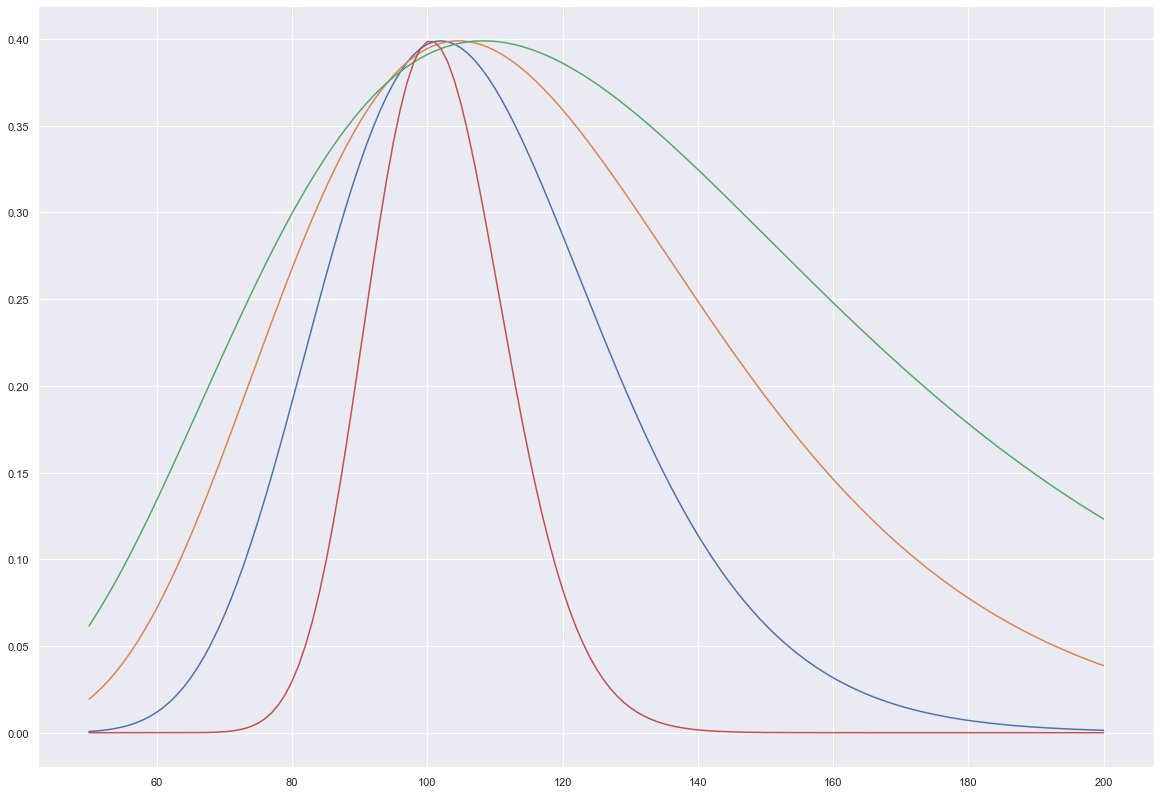

In [47]:
lower = 0.5
upper = 2.0
diff = 0.10

strikes = np.linspace(lower, upper, int((upper - lower)*100 + 1)) * px


fig, ax = plt.subplots(figsize=(20,14))

ax.plot(strikes, [stats.norm.pdf(bs_d_one(px, x, risk_free, divs, sigma, years)) for x in strikes])
ax.plot(strikes, [stats.norm.pdf(bs_d_one(px, x, risk_free, divs, sigma + diff, years)) for x in strikes])
ax.plot(strikes, [stats.norm.pdf(bs_d_one(px, x, risk_free, divs, sigma + 2*diff, years)) for x in strikes])
ax.plot(strikes, [stats.norm.pdf(bs_d_one(px, x, risk_free, divs, sigma - diff, years)) for x in strikes]);

In [138]:
px = 100
risk_free = 0.00
divs = 0.00
sigma = 0.2
years = 1
points = 252*4
sims = 10000

strike = 150

In [139]:
# create implied vol series
ivs = np.tile([sigma - 0.1, sigma + 0.1], (points * years) // 2)
ivs = np.append(sigma, ivs)

In [140]:
pxs, rets, call_pxs, repls, deltas, gammas, vegas = run_delta_hedge_sim(px, strike, risk_free, divs, sigma, years, points, sims)

In [141]:
pxs, rets, call_pxs_sv, repls_sv, deltas_sv, gammas_sv, vegas_sv = run_delta_hedge_sim(px, strike, risk_free, divs, sigma, years, points, sims, iv=ivs, hedge_vol=ivs)

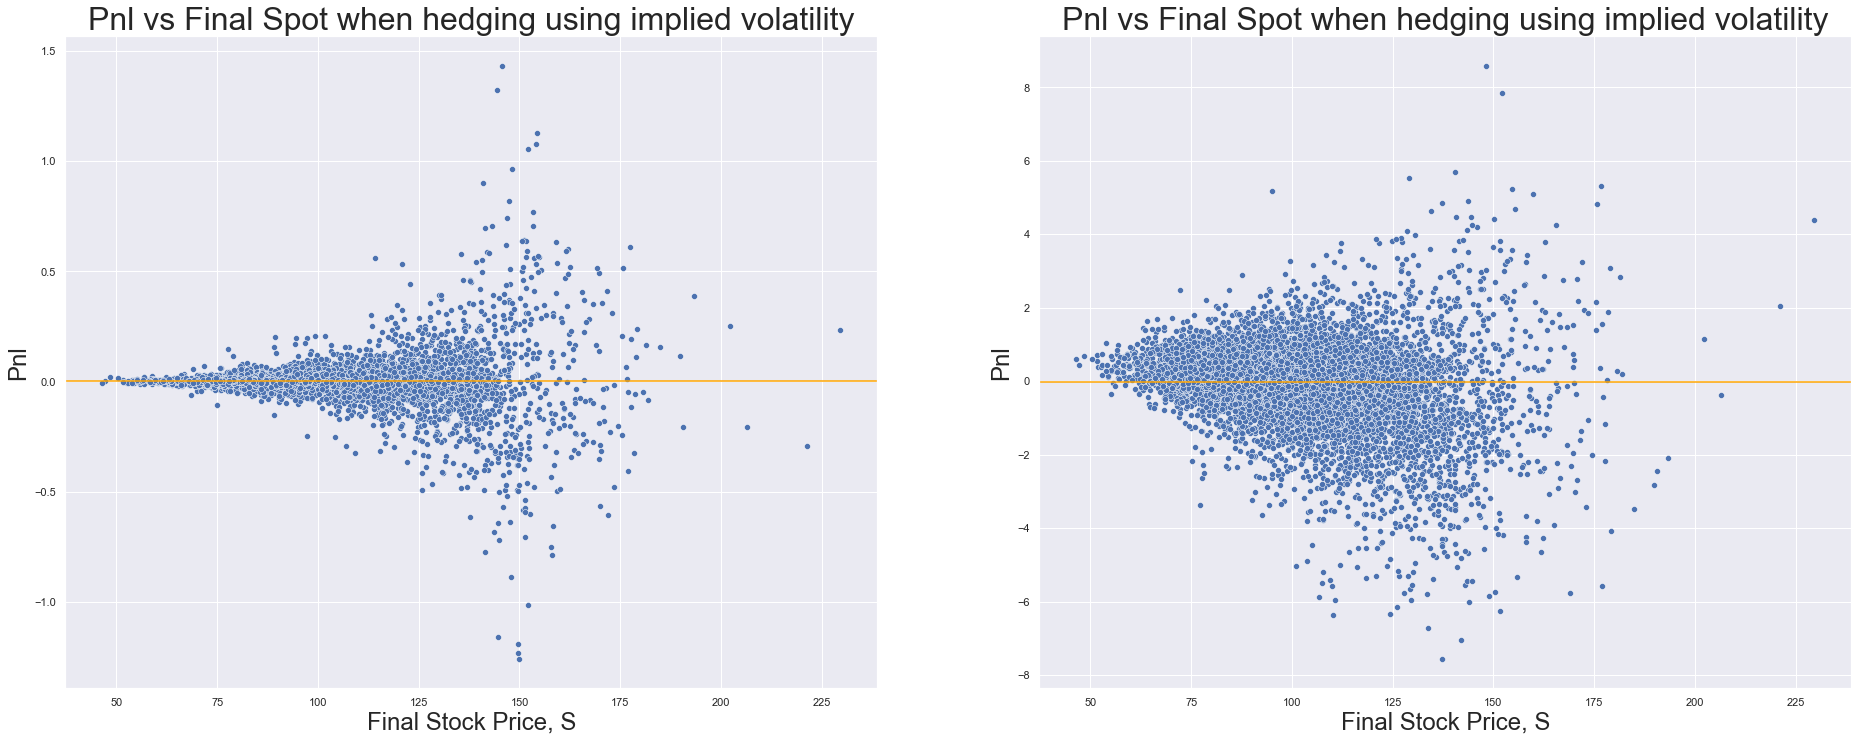

In [142]:
prices = pxs[:, -1]
call_prices = call_pxs[:, -1]
repl_pxs = repls[:, -1]

call_prices_sv = call_pxs_sv[:, -1]
repl_pxs_sv = repls_sv[:, -1]

fig, axes = plt.subplots(ncols=2, figsize=(32,12))
axes = axes.reshape(-1)

sns.scatterplot(prices, call_prices - repl_pxs, ax=axes[0])

axes[0].axhline(np.mean(call_prices - repl_pxs), color='orange')
axes[0].set_title('Pnl vs Final Spot when hedging using implied volatility', fontsize=32)
axes[0].set_xlabel('Final Stock Price, S', fontsize=24)
axes[0].set_ylabel('Pnl', fontsize=24)
# axes[0].set_ylim(-2, 6)

sns.scatterplot(prices, call_prices_sv - repl_pxs_sv, ax=axes[1])

axes[1].axhline(np.mean(call_prices_sv - repl_pxs_sv), color='orange')
axes[1].set_title('Pnl vs Final Spot when hedging using implied volatility', fontsize=32)
axes[1].set_xlabel('Final Stock Price, S', fontsize=24)
axes[1].set_ylabel('Pnl', fontsize=24);
# axes[1].set_ylim(-2, 6);

In [143]:
np.mean(call_prices_sv - repl_pxs_sv)

-0.0275628647727586

0.0004467763726754832

Plan:
 - show how simple alternating vol regime leads to positive pnl when you own options
 - in order to compensate we'd need a higher implied vol - higher than is actually realised to have a flat breakeven
 - in other words the black scholes world starts to break down because there is only one theta related to spot that can be used to offset
 - to understand why vanilla options have exposure to stochastic volatility we need to look at the vega
 - we can plot the vega of different vanilla options according to their moneyness
 - we can then plot this vega for various levels of implied vol [10, 15, 20] - 15-20 should be further apart than 10-15
 - in simple terms if we are buying and selling options we can explain why vega convexity leads to pnl
 - but how can this even be monetised just by using delta hedging?
 - for that we need to understand how the implied volatility impacts our delta
 - scenario 1 - long OTM call with spot up vol up, spot down vol down
 - scenario 2 - long OTM call with spot up vol down, spot down vol up
 - comparison between the 2 s.t. gain from scenario 1 > loss from scenario 2
 - why? because the delta increases by more in scenario 1 than it decreases in scenario 2 so we'd on average make from this happening and then repeating itself
 